In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import math
import scipy
import pandas as pd
from IPython.display import Image
from torch.distributions import MultivariateNormal
from sklearn.preprocessing import normalize, scale

#import models
from models import ScoreNet_BOD, cde_ScoreNet_BOD

#import training fns
from training import loss_fn, train_model, CDE_loss_fn_BOD

#import SDE functions
from SDE import marginal_prob_std_fn_BOD as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_BOD as diffusion_coeff_fn

#import sampling fns
from sampling import pc_sampler_BOD as pc_sampler
from sampling import Euler_Maruyama_sampler_BOD as Euler_Maruyama_sampler
from sampling import CDiffE_Euler_Maruyama_sampler_BOD as CDiffE_Euler_Maruyama_sampler
from sampling import CDiffE_pc_sampler_BOD as CDiffE_pc_sampler
from sampling import CDE_pc_sampler_BOD as CDE_pc_sampler
from sampling import CDE_Euler_Maruyama_sampler_BOD as CDE_Euler_Maruyama_sampler
from sampling import SMCDiff_pc_sampler_BOD as SMCDiff_pc_sampler
from sampling import SMCDiff_Euler_Maruyama_sampler_BOD as SMCDiff_Euler_Maruyama_sampler
from sampling import get_diffused_BOD, sde_VE

# Generate training dataset

In [331]:
data = torch.load('data/BOD.pt')

In [332]:
means = torch.mean(data, axis=0)
sds = torch.sqrt(torch.var(data, axis=0))

In [333]:
x = torch.tensor(scale(data))

In [5]:
from data import find_max_dist

In [6]:
find_max_dist(x)

12.692815907935616

In [23]:
find_max_dist(data)

8.80109

In [5]:
x*sds + means

tensor([[-0.1116, -1.0656,  0.0262,  ...,  0.0787,  0.1151,  0.1930],
        [-0.7194,  0.5121,  0.0568,  ...,  0.3392,  0.3513,  0.4018],
        [-1.0135, -0.5175,  0.0468,  ...,  0.1890,  0.1575,  0.1812],
        ...,
        [-0.1257,  0.7160,  0.1857,  ...,  0.3575,  0.4924,  0.4890],
        [ 0.4230,  0.2200,  0.1414,  ...,  0.3968,  0.4806,  0.5404],
        [ 2.6459,  0.0237,  0.1933,  ...,  0.5173,  0.5247,  0.6312]],
       dtype=torch.float64)

In [6]:
data

tensor([[-0.1116, -1.0655,  0.0262,  ...,  0.0787,  0.1151,  0.1930],
        [-0.7194,  0.5121,  0.0568,  ...,  0.3392,  0.3513,  0.4018],
        [-1.0135, -0.5175,  0.0468,  ...,  0.1890,  0.1575,  0.1812],
        ...,
        [-0.1257,  0.7160,  0.1857,  ...,  0.3575,  0.4924,  0.4890],
        [ 0.4230,  0.2200,  0.1414,  ...,  0.3968,  0.4806,  0.5404],
        [ 2.6459,  0.0237,  0.1933,  ...,  0.5173,  0.5247,  0.6312]])

In [7]:
x

tensor([[-0.1178, -1.0689, -1.1717,  ..., -1.2835, -1.2411, -1.0056],
        [-0.7252,  0.5083, -0.7742,  ...,  0.3032, -0.0141, -0.0270],
        [-1.0191, -0.5210, -0.9047,  ..., -0.6115, -1.0211, -1.0611],
        ...,
        [-0.1319,  0.7121,  0.9008,  ...,  0.4146,  0.7186,  0.3819],
        [ 0.4164,  0.2162,  0.3245,  ...,  0.6540,  0.6571,  0.6227],
        [ 2.6376,  0.0200,  0.9992,  ...,  1.3880,  0.8866,  1.0483]],
       dtype=torch.float64)

# Train unconditional model

In [8]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)

In [10]:
losses = train_model(score_model, x, loss_fn, marginal_prob_std_fn, 'BOD_rescaled.pth', epochs = 200, batch_size = 64)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


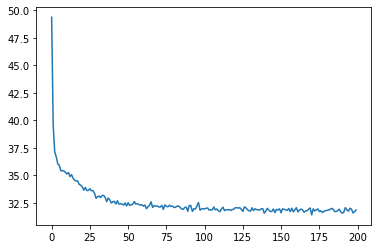

In [11]:
plt.plot(losses)

# Draw unconditional samples

In [327]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']
    sns.displot(df, x ='x1', y='x2', kind="kde")

In [335]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [14]:
pc_samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000, eps=1e-5)
pc_samples = pc_samples*sds + means

  0%|          | 0/1000 [00:00<?, ?it/s]

In [336]:
e_m_samples = Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000, eps=1e-5)
e_m_samples = e_m_samples*sds + means

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
torch.mean(pc_samples, axis=0)

tensor([-0.3876,  0.0274,  0.1455,  0.2003,  0.2491,  0.3108,  0.3613])

In [17]:
torch.mean(data, axis=0)

tensor([0.0063, 0.0037, 0.1164, 0.2113, 0.2894, 0.3541, 0.4075])

In [18]:
torch.var(pc_samples, axis=0)

tensor([0.9895, 1.6931, 0.0044, 0.0165, 0.0280, 0.0382, 0.0432])

In [19]:
torch.var(data, axis=0)

tensor([1.0015, 1.0007, 0.0059, 0.0160, 0.0270, 0.0371, 0.0455])

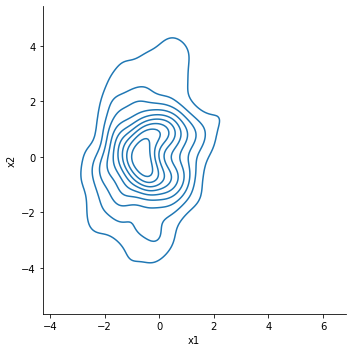

In [20]:
density_plot(pc_samples)

In [21]:
torch.mean(e_m_samples, axis=0)

tensor([-0.0561,  0.0099,  0.1147,  0.2109,  0.2855,  0.3538,  0.4041])

In [22]:
torch.mean(data, axis=0)

tensor([0.0063, 0.0037, 0.1164, 0.2113, 0.2894, 0.3541, 0.4075])

In [23]:
torch.var(e_m_samples, axis=0)

tensor([1.0149, 1.1474, 0.0062, 0.0172, 0.0289, 0.0389, 0.0467])

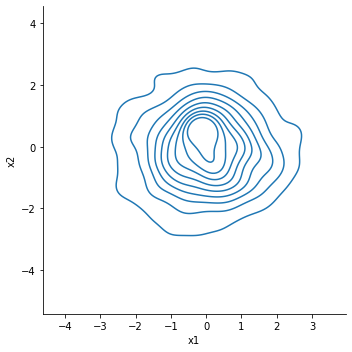

In [337]:
density_plot(e_m_samples)

<hr style="border:2px solid black">

# CDiffE replacement method

## Draw CDiffE samples

In [5]:
y_obs = torch.tensor([0.18, 0.32, 0.42, 0.49, 0.54])
y_obs = (y_obs - means[[2,3,4,5,6]])/sds[[2,3,4,5,6]]

In [7]:
diffused_y = [get_diffused_BOD(y_obs, 1000, sde_VE, 0.01, 13) for i in range(10)]

In [8]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000, diffused_y = diffused_y[0])
cdiffe_samples = cdiffe_samples * sds + means
cdiffe = [cdiffe_samples]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
for i in range(1,10):
    new_sample = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000, diffused_y = diffused_y[i])
    new_sample = new_sample * sds + means
    cdiffe.append(new_sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
cdiffe_samples = torch.vstack(cdiffe)

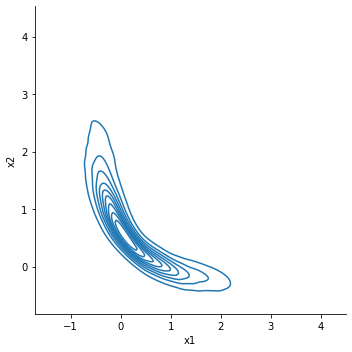

In [11]:
density_plot(cdiffe_samples)

In [12]:
torch.mean(cdiffe_samples, axis=0)

tensor([0.2538, 0.6224, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])

In [13]:
torch.var(cdiffe_samples[:, [0,1]], axis=0)

tensor([0.3589, 0.3776])

In [14]:
scipy.stats.skew(cdiffe_samples[:, [0,1]])

array([1.3121053 , 0.99130344], dtype=float32)

In [15]:
scipy.stats.kurtosis(cdiffe_samples[:, [0,1]])

array([2.1335168, 1.2522831], dtype=float32)

In [16]:
cdiffe_means = [torch.mean(cdiffe[i], axis=0) for i in range(10)]

In [17]:
cdiffe_means

[tensor([0.2687, 0.6193, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2786, 0.6092, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2447, 0.6787, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2081, 0.6127, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1691, 0.6856, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.3392, 0.5494, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1784, 0.7402, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2603, 0.5941, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.3375, 0.5054, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2532, 0.6296, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

<hr style="border:2px solid black">

# CDE tailored conditional method

## Train conditioned model

In [39]:
score_model = cde_ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
losses_cde = train_model(score_model, x, CDE_loss_fn_BOD, marginal_prob_std_fn, 'BOD_cde_rescaled.pth', epochs = 200, batch_size = 64)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


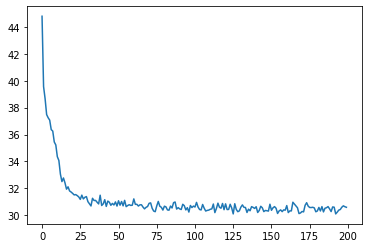

In [40]:
plt.plot(losses_cde)

## Draw CDE samples

In [197]:
y_obs

tensor([0.8264, 0.8592, 0.7954, 0.7061, 0.6209])

In [47]:
score_model = cde_ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD_cde.pth')
score_model.load_state_dict(ckpt)
cde_samples = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 10000)
cde_samples = cde_samples * sds + means
cde = [cde_samples]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
for i in range(9):
    new_sample = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000)
    new_sample = new_sample * sds + means
    cde.append(new_sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
cde_samples = torch.vstack(cde)

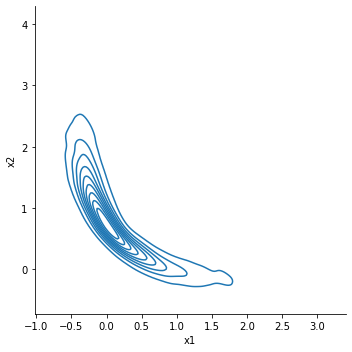

In [48]:
density_plot(cde_samples)

In [49]:
torch.mean(cde_samples, axis=0)

tensor([0.1068, 0.8321, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])

In [50]:
torch.var(cde_samples[:,[0,1]], axis=0)

tensor([0.1988, 0.3515])

In [51]:
scipy.stats.skew(cde_samples[:,[0,1]])

array([1.7603834 , 0.67743087], dtype=float32)

In [52]:
scipy.stats.kurtosis(cde_samples[:,[0,1]])

array([4.211728 , 0.5084286], dtype=float32)

In [26]:
cde_means = [torch.mean(cde[i], axis=0) for i in range(10)]

In [27]:
cde_means

[tensor([0.0950, 0.8276, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1200, 0.8147, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1082, 0.8373, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1059, 0.8267, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1006, 0.8695, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1277, 0.8089, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1270, 0.8048, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0926, 0.8519, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1260, 0.8113, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1096, 0.8453, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

<hr style="border:2px solid black">

# SMCDiff method

## Draw SMCDiff samples

In [53]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)

smcdiff_samples = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, k = 1000, diffused_y = diffused_y[0])
smcdiff_samples = smcdiff_samples * sds + means
smcdiff = [smcdiff_samples]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

644 resampling, departure=503.17
383 resampling, departure=515.07


In [54]:
for i in range(1,10):
    new_sample = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, k = 1000, diffused_y = diffused_y[i])
    new_sample = new_sample * sds + means
    smcdiff.append(new_sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

551 resampling, departure=530.04
491 resampling, departure=516.99
415 resampling, departure=504.56


  0%|          | 0/1000 [00:00<?, ?it/s]

531 resampling, departure=503.43
410 resampling, departure=505.40


  0%|          | 0/1000 [00:00<?, ?it/s]

517 resampling, departure=509.83
358 resampling, departure=501.11


  0%|          | 0/1000 [00:00<?, ?it/s]

596 resampling, departure=534.93
333 resampling, departure=502.12
272 resampling, departure=524.15


  0%|          | 0/1000 [00:00<?, ?it/s]

521 resampling, departure=500.98
39 resampling, departure=501.14


  0%|          | 0/1000 [00:00<?, ?it/s]

644 resampling, departure=501.48
388 resampling, departure=504.36
298 resampling, departure=508.56
102 resampling, departure=501.57


  0%|          | 0/1000 [00:00<?, ?it/s]

571 resampling, departure=512.33
388 resampling, departure=502.21


  0%|          | 0/1000 [00:00<?, ?it/s]

399 resampling, departure=501.82
267 resampling, departure=519.30


  0%|          | 0/1000 [00:00<?, ?it/s]

492 resampling, departure=539.34
414 resampling, departure=532.31
320 resampling, departure=500.51


In [55]:
smcdiff_samples = torch.vstack(smcdiff)

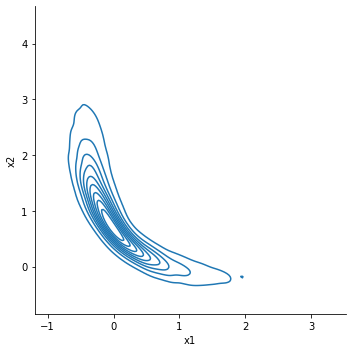

In [56]:
density_plot(smcdiff_samples)

In [57]:
torch.mean(smcdiff_samples, axis=0)

tensor([0.0600, 0.8892, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])

In [58]:
torch.var(smcdiff_samples[:,[0,1]], axis=0)

tensor([0.2237, 0.4445])

In [59]:
scipy.stats.skew(smcdiff_samples[:,[0,1]])

array([1.9453561, 0.7648963], dtype=float32)

In [60]:
scipy.stats.kurtosis(smcdiff_samples[:,[0,1]])

array([5.57327  , 0.6612041], dtype=float32)

In [36]:
smcdiff_means = [torch.mean(smcdiff[i], axis=0) for i in range(10)]

In [37]:
smcdiff_means

[tensor([0.0331, 0.9047, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1949, 0.7117, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1339, 0.8409, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0771, 0.8474, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0372, 0.9558, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0769, 0.8143, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([-0.0382,  0.9475,  0.1800,  0.3200,  0.4200,  0.4900,  0.5400]),
 tensor([0.1380, 0.7210, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1073, 0.7820, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0041, 0.8927, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

<hr style="border:2px solid black">

# Comparison

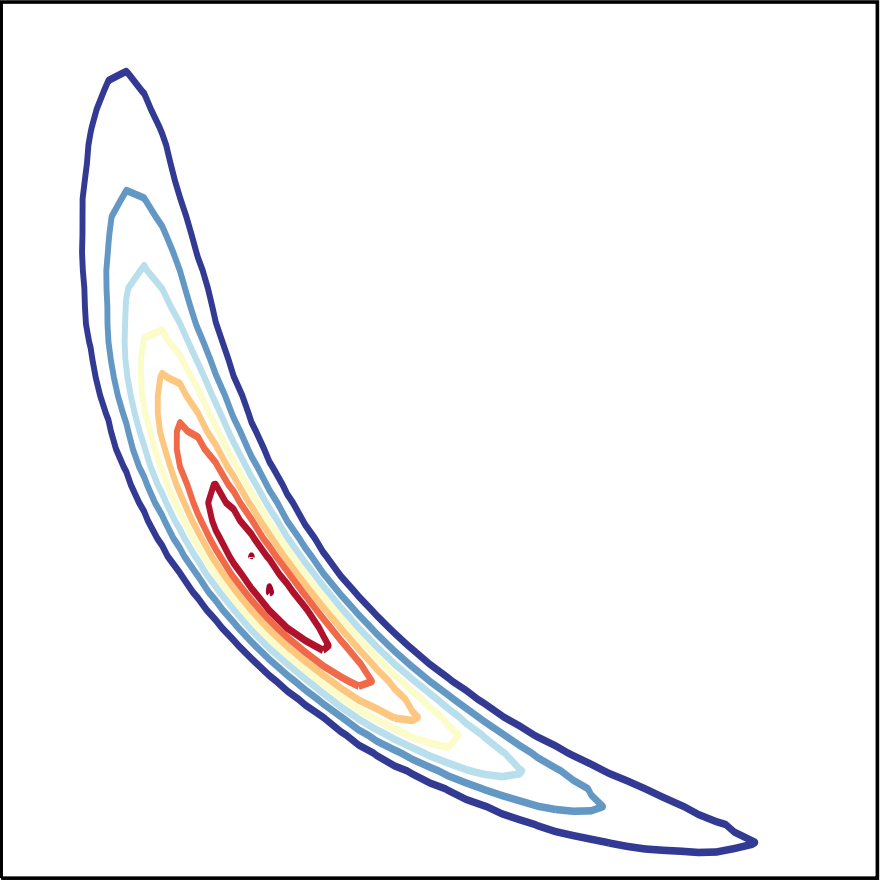

In [38]:
Image("plots/BOD target density.png", width=300, height=300)
#make my own version with scale? would need to generate MCMC points

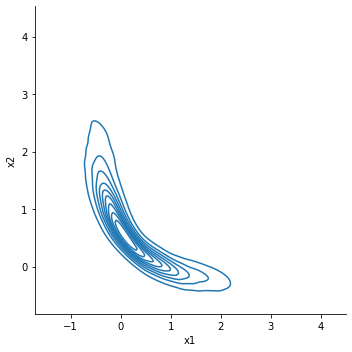

In [39]:
density_plot(cdiffe_samples)

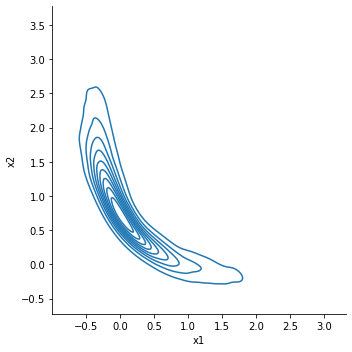

In [40]:
density_plot(cde_samples)

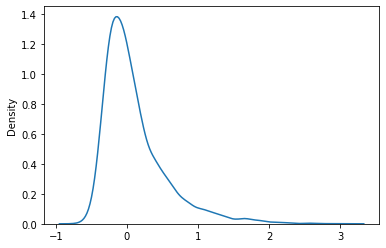

In [75]:
sns.kdeplot(cde_samples[:,0])

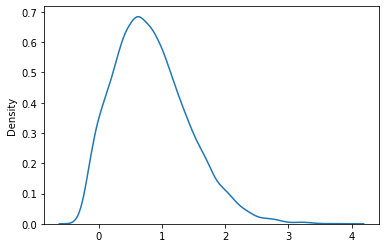

In [76]:
sns.kdeplot(cde_samples[:,1])

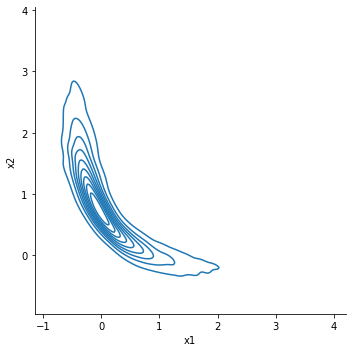

In [41]:
density_plot(smcdiff_samples)

In [183]:
cdiffe_means

[tensor([0.1761, 0.6763, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.4196, 0.4834, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2767, 0.5775, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2802, 0.6881, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1739, 0.6088, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.3866, 0.5059, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2382, 0.6217, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.3937, 0.6688, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2709, 0.6804, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2276, 0.6485, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

In [184]:
cde_means

[tensor([0.1256, 0.8158, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1119, 0.8385, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1280, 0.8427, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1269, 0.8399, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1286, 0.8188, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1029, 0.8331, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1187, 0.8107, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1118, 0.8409, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1082, 0.8507, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.1176, 0.8165, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

In [185]:
smcdiff_means

[tensor([0.1786, 0.6565, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.2298, 0.6710, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0958, 0.7791, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0409, 0.8793, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0274, 0.9328, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0957, 0.8151, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0413, 0.8844, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([0.0525, 0.8629, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400]),
 tensor([-0.0507,  1.0656,  0.1800,  0.3200,  0.4200,  0.4900,  0.5400]),
 tensor([0.1336, 0.7513, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])]

In [186]:
torch.mean(torch.vstack(smcdiff_means)[:, [0,1]], axis=0)

tensor([0.0845, 0.8298])

In [187]:
torch.mean(torch.vstack(cdiffe_means)[:, [0,1]], axis=0)

tensor([0.2844, 0.6159])

In [188]:
torch.mean(torch.vstack(cde_means)[:, [0,1]], axis=0)

tensor([0.1180, 0.8308])

In [189]:
torch.var(torch.vstack(smcdiff_means)[:, [0,1]], axis=0)

tensor([0.0066, 0.0152])

In [190]:
torch.var(torch.vstack(cdiffe_means)[:, [0,1]], axis=0)

tensor([0.0078, 0.0053])

In [191]:
torch.var(torch.vstack(cde_means)[:, [0,1]], axis=0)

tensor([8.3293e-05, 1.9622e-04])

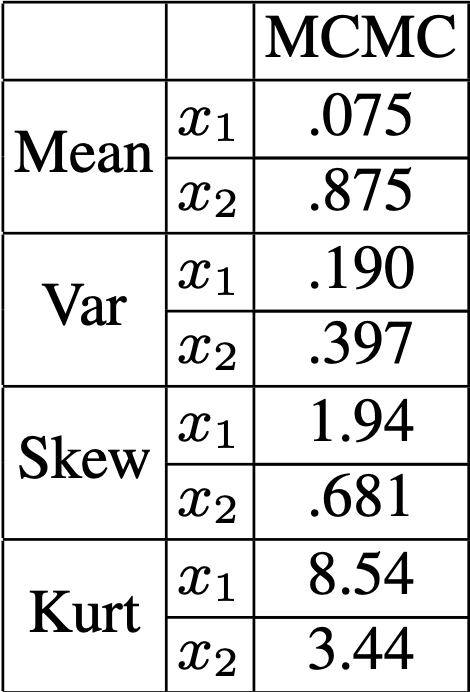

In [61]:
Image("plots/BOD target stats.png", width=300, height=300)

In [62]:
cdiffe_mean = torch.mean(cdiffe_samples[:, [0,1]], axis=0).reshape(2,1)
cde_mean = torch.mean(cde_samples[:, [0,1]], axis=0).reshape(2,1)
smc_mean = torch.mean(smcdiff_samples[:, [0,1]], axis=0).reshape(2,1)

sample_means = torch.hstack([cdiffe_mean, cde_mean, smc_mean])
sample_means

tensor([[0.2538, 0.1068, 0.0600],
        [0.6224, 0.8321, 0.8892]])

In [63]:
cdiffe_var = torch.var(cdiffe_samples[:, [0,1]], axis=0).reshape(2,1)
cde_var = torch.var(cde_samples[:, [0,1]], axis=0).reshape(2,1)
smc_var = torch.var(smcdiff_samples[:, [0,1]], axis=0).reshape(2,1)

var = torch.hstack([cdiffe_var, cde_var, smc_var])
var

tensor([[0.3589, 0.1988, 0.2237],
        [0.3776, 0.3515, 0.4445]])

In [64]:
cdiffe_skew = scipy.stats.skew(cdiffe_samples[:, [0,1]], axis=0)
cde_skew = scipy.stats.skew(cde_samples[:, [0,1]], axis=0)
smc_skew = scipy.stats.skew(smcdiff_samples[:, [0,1]], axis=0)

skew = np.stack([cdiffe_skew, cde_skew, smc_skew])
skew.T

array([[1.3121053 , 1.7603834 , 1.9453561 ],
       [0.99130344, 0.67743087, 0.7648963 ]], dtype=float32)

In [65]:
cdiffe_kurt = scipy.stats.kurtosis(cdiffe_samples[:, [0,1]], axis=0)
cde_kurt = scipy.stats.kurtosis(cde_samples[:, [0,1]], axis=0)
smc_kurt = scipy.stats.kurtosis(smcdiff_samples[:, [0,1]], axis=0)

kurt = np.stack([cdiffe_kurt, cde_kurt, smc_kurt])
kurt.T

array([[2.1335168, 4.211728 , 5.57327  ],
       [1.2522831, 0.5084286, 0.6612041]], dtype=float32)

# Trying to generate own MCMC samples for true distribution

In [2]:
y = [0.18,0.32,0.42,0.49,0.54]

In [72]:
def log_prob(x_1, x_2, y):
    x_1 = torch.tensor(x_1)
    x_2 = torch.tensor(x_2)
    theta_0 = 0.8+0.4*torch.erf(x_1/np.sqrt(2))
    theta_1 = 0.16+0.15*torch.erf(x_2/np.sqrt(2))
    prob = [(theta_0 * (1-torch.exp(-theta_1*(i+1))) - y[i])**2 for i in range(5)]
    prob = sum(prob).item()
    prob = - 1/(2*1e-3) * prob
    return prob

In [3]:
def log_prob(x_1, x_2, y):
    theta_0 = torch.tensor(x_1)
    theta_1 = torch.tensor(x_2)
    
    prob = [(theta_0 * (1-torch.exp(-theta_1*(i+1))) - y[i])**2 for i in range(5)]
    prob = sum(prob).item()
    prob = - 1/(2*1e-3) * prob
    return prob

In [73]:
from scipy.stats import multivariate_normal
dens = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])

In [166]:
(np.random.rand() - 1/2)*0.01

0.0003307690028611199

In [4]:
xs = []
x_1 = 0.825
x_2 = 0.253
x = (x_1,x_2)
xs.append(x)
acc=0

one_or_two = 1
for i in range(1000000):
    x_1 = xs[-1][0]
    x_2 = xs[-1][1]
    
    if one_or_two%2:
        x_1_new =  x_1 + (np.random.rand() - 1/2)*0.25
        x_2_new = x_2
    else:
        x_1_new = x_1
        x_2_new =  x_2 + (np.random.rand() - 1/2)*0.25

    one_or_two += 1
    p = min(1, np.exp(log_prob(x_1_new, x_2_new, y) - log_prob(x_1, x_2,y)))
    
    u = np.random.rand()
    
    if u <= p and (0.4 < x_1_new) and (x_1_new < 1.2) and (0.01 < x_2_new) and (x_2_new < 0.31):
        x = (x_1_new, x_2_new)
        acc+=1
    else:
        x = (x_1,x_2)
        
    xs.append(x)

In [5]:
acc/1000000

0.251352

In [6]:
x_1s = [i[0] for i in xs]
x_2s = [i[1] for i in xs]

In [299]:
sorted(x_1s)[-1]

1.1997912339196357

In [12]:
y_1s = [get_x_1(i) for i in x_1s]
y_2s = [get_x_2(i) for i in x_2s]

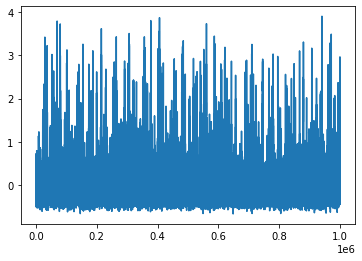

In [13]:
plt.plot(y_1s)

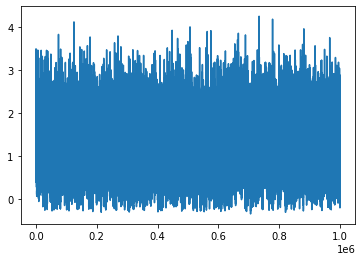

In [14]:
plt.plot(y_2s)

In [15]:
np.mean(y_1s[40000:])

0.05399305551475369

In [16]:
np.mean(y_2s[40000:])

0.9192256035512968

In [17]:
y_1s_burnt = torch.tensor(y_1s[40000:])[:,None]

In [18]:
y_2s_burnt = torch.tensor(y_2s[40000:])[:,None]

In [19]:
ys = torch.hstack([y_1s_burnt, y_2s_burnt])

In [20]:
idx = np.random.choice(960000, 10000)

In [21]:
samples = ys[idx]

In [353]:
samples

tensor([[ 0.2598,  0.4476],
        [ 0.0157,  0.7226],
        [-0.1969,  1.0876],
        ...,
        [-0.2363,  1.3607],
        [ 0.3238,  0.2487],
        [ 0.0725,  0.6130]], dtype=torch.float64)

In [312]:
from random import sample

In [319]:
samples_1 = torch.tensor(sample(y_1s[40000:], 1000))

In [320]:
samples_2 = torch.tensor(sample(y_2s[40000:], 1000))

In [325]:
samples = torch.hstack([samples_1[:,None], samples_2[:,None]])

In [22]:
def density_plot_2D(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

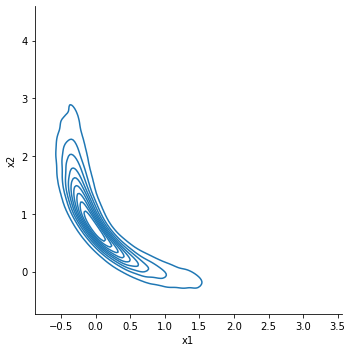

In [23]:
density_plot_2D(samples)

In [25]:
torch.save(samples, 'data/BOD_mcmc_with_burn.pt')

In [ ]:
total_mcmc = torch.

In [329]:
samples

tensor([[ 0.8419,  0.8773],
        [-0.0666,  2.0116],
        [ 0.1221,  1.9072],
        ...,
        [-0.3677,  0.1898],
        [-0.3668,  0.9948],
        [-0.2538,  1.2361]], dtype=torch.float64)

In [241]:
erfinv(0.999999)

3.458910737275499

In [11]:
from scipy.special import erfinv

In [8]:
def get_x_1(theta_0):
    return np.sqrt(2) * erfinv((theta_0 - 0.8)/0.4)

In [9]:
def get_x_2(theta_1):
    return np.sqrt(2) * erfinv((theta_1 - 0.16)/0.15)

In [205]:
probs = [np.exp(log_prob(0.5, i, y))/(np.pi**(5/2) * np.sqrt(1e-15)) for i in np.linspace(0.01, 0.31, 100000)]

In [206]:
sum(probs)

3.551051888136619e-05

In [81]:
torch.erf(torch.tensor(1))

tensor(0.8427)

In [83]:
torch.exp(1)

TypeError: exp(): argument 'input' (position 1) must be Tensor, not int

In [105]:
[(theta_0 * (1-torch.exp(-theta_1*(i+1))) - y[i])**2 for i in range(5)]

[tensor(1.6162e-05, dtype=torch.float64),
 tensor(4.8160e-05, dtype=torch.float64),
 tensor(0.0003, dtype=torch.float64),
 tensor(0.0012, dtype=torch.float64),
 tensor(0.0026, dtype=torch.float64)]

In [109]:
np.random.randn()

-2.1668712146418936

In [111]:
min(1,2,0.5)

0.5

In [112]:
np.exp(1)

2.718281828459045

In [114]:
np.random.rand()

0.48972045751201987

0.0

In [25]:
[0.8+0.4*torch.erf(i/np.sqrt(2)) for i in torch.linspace(-4,4,1000)]

[tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4001),
 tensor(0.4002),
 tensor(0.4002),
 tensor(0.4002

In [26]:
[0.16+0.15*torch.erf(i/np.sqrt(2)) for i in torch.linspace(-4,4,1000)]

[tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0100),
 tensor(0.0101),
 tensor(0.0101),
 tensor(0.0101),
 tensor(0.0101),
 tensor(0.0101),
 tensor(0.0101),
 tensor(0.0101